In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from sklearn.preprocessing import LabelEncoder
from geopy.geocoders import Yandex
from geopy.distance import vincenty
import time
from tqdm import tqdm

In [164]:
train = pd.read_csv('data/train_set.csv')
test = pd.read_csv('data/test_set.csv')

train.rename(columns={ 'pos_adress_lat' : 'pos_address_lat', 
                       'pos_adress_lon' : 'pos_address_lon'}, inplace=True)

D:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (1,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (1,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [169]:
# Заполнение пропуска координат дома
customer = train['customer_id'][train['home_add_lon'].isnull() == True].unique()[0]
train['home_add_lon'][train['customer_id'] == customer] = train['home_add_lon'][train['customer_id'] == customer].fillna(method='bfill').fillna(method='ffill')
train['home_add_lat'][train['customer_id'] == customer] = train['home_add_lat'][train['customer_id'] == customer].fillna(method='bfill').fillna(method='ffill')

#Удалить клиентов, у которых нет работы
train.drop(train[train['work_add_lon'].isnull() == True].index,inplace=True)

# Удалить транзакции, где нет адреса координат atm, pos и terminal_id (в трейне это все строчки, где нет terminal_id)
train.drop(train[train['terminal_id'].isnull() == True].index, axis=0, inplace=True)

###########################################################################################
# Подсчет частот адресов
atm_address_count = train['atm_address'].value_counts()

# Удаление транзакций с atm_address = "RADNAYA\             RUS,445" (по нему координат нет)
# train.drop(train[train['atm_address'] == atm_address_count.index[45]].index, axis=0, inplace=True)

# Замена 'Подольск, ул. Полевановская, д. 9, (Заезд с ул. Орджоникидзе д. 25)' на 'Подольск, ул. Полевановская, д. 9'
train['atm_address'].replace(to_replace=atm_address_count.index[46], value='Подольск, ул. Полевановская, д. 9', inplace=True)

############################################################################################
# Адреса с '\' в названии (частоты)
backslash_atm_address_count = train['atm_address'][train['atm_address'].str.contains("\\\\") == True].value_counts()

# Замены до частоты 100 более-менее читаемых адресов
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[1], value='улица Маросейка, 3/13с1, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[9], value='улица Савушкина, 141, Санкт-Петербург', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[12], value='Новомытищинский проспект, 34, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[14], value='проспект Большевиков, 18, Санкт-Петербург', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[15], value='Марксистская улица, 1, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[16], value='Гражданский проспект, 41к2, Санкт-Петербург', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[18], value='улица Грекова, 8, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[23], value='Ракетный бульвар, 16, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[27], value='Новочеркасский проспект, 43/17, Санкт-Петербург', inplace=True)

# Остальные удалить
train.drop(train[train['atm_address'].str.contains("\\\\") == True].index, inplace=True)

############################################################################################
# Для удобства анализа сделаю labelencoding на customer_id и terminal_id
label_encoder = LabelEncoder()
train['customer_id'] = label_encoder.fit_transform(train['customer_id'])
train['terminal_id'] = label_encoder.fit_transform(train['terminal_id'])

#############################################################################################
# Обнуление NaN адресов atm и pos
train[['atm_address', 'atm_address_lat', 'atm_address_lon',
       'pos_address', 'pos_address_lat', 'pos_address_lon']] = train[['atm_address', 'atm_address_lat', 'atm_address_lon', 
                                                                      'pos_address', 'pos_address_lat', 'pos_address_lon']].fillna(0)
#######################################################################################################

# у 13 pos адресов координаты разные - исправляем
wrong_pos_address = []
with open('pos_address.txt', 'r') as file:
    for line in file:
        wrong_pos_address.append(line.strip())
        
geolocator = Yandex()

#0
location = geolocator.geocode('B. KAMENSCHIKI, 4MOSCOW')
#pos = train[train['pos_address'] == wrong_pos_address[0]]
#pos = pos.groupby(['pos_address_lat', 'pos_address_lon']).size().reset_index().rename(columns={0:'count'})

train['pos_address_lat'][train['pos_address'] == wrong_pos_address[0]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[0]] = location.longitude

#1
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[1]] = 59.2243102
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[1]] = 39.8657153

#2 под вопросом, потому что обе точки имеют место быть
#train['pos_address_lat'][train['pos_address'] == wrong_pos_address[2]] = 55.7955715
#train['pos_address_lon'][train['pos_address'] == wrong_pos_address[2]] = 37.5937033

#3 
# тоже обе точки могут быть

#4
time.sleep(0.5)
location = geolocator.geocode("5-1A, SUSCHEVSKIY VALMOSKVA")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[4]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[4]] = location.longitude

#5
time.sleep(0.5)
location = geolocator.geocode("'KOMMUNISTICHESKAYA STR 1MYTISCHY")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[5]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[5]] = location.longitude

#6
time.sleep(0.5)
location = geolocator.geocode("MIRA STR 51MYTISCHY")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[6]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[6]] = location.longitude

#7
time.sleep(0.5)
location = geolocator.geocode("42, SCHUKINSKAYA MOSKVA")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[7]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[7]] = location.longitude

#8
#нормальная, отличие в 8 незначящем знаке

#9
time.sleep(0.5)
location = geolocator.geocode("2, VETERANOV MYTISCHI")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[9]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[9]] = location.longitude

#10
time.sleep(0.5)
location = geolocator.geocode("55 BOLSHOY SAMPSONIEVSKIY PR SANKT-PETERBURG")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[10]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[10]] = location.longitude

#11
time.sleep(0.5)
location = geolocator.geocode("20 BOLSHOY SAMPSONIEVSKIY PRSANKT-PETERBURG")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[11]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[11]] = location.longitude

#12
time.sleep(0.5)
location = geolocator.geocode("Счастливая улица, 11, Усады")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[12]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[12]] = location.longitude

D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:67: Settin

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1144721 entries, 0 to 1224733
Data columns (total 18 columns):
amount              1144721 non-null float64
atm_address         1144721 non-null object
atm_address_lat     1144721 non-null float64
atm_address_lon     1144721 non-null float64
city                1144712 non-null object
country             1144721 non-null object
currency            1144677 non-null float64
customer_id         1144721 non-null int64
home_add_lat        1144721 non-null float64
home_add_lon        1144721 non-null float64
mcc                 1144721 non-null int64
pos_address         1144721 non-null object
pos_address_lat     1144721 non-null float64
pos_address_lon     1144721 non-null float64
terminal_id         1144721 non-null int64
transaction_date    1144677 non-null object
work_add_lat        625352 non-null float64
work_add_lon        625352 non-null float64
dtypes: float64(10), int64(3), object(5)
memory usage: 165.9+ MB


In [165]:
atm_train = train[train['atm_address']!=0]

In [88]:
atm_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107357 entries, 942661 to 1224713
Data columns (total 18 columns):
amount              107357 non-null float64
atm_address         107357 non-null object
atm_address_lat     107357 non-null float64
atm_address_lon     107357 non-null float64
city                107357 non-null object
country             107357 non-null object
currency            107357 non-null float64
customer_id         107357 non-null int64
home_add_lat        107357 non-null float64
home_add_lon        107357 non-null float64
mcc                 107357 non-null int64
pos_address         107357 non-null object
pos_address_lat     107357 non-null float64
pos_address_lon     107357 non-null float64
terminal_id         107357 non-null int64
transaction_date    107357 non-null object
work_add_lat        107357 non-null float64
work_add_lon        107357 non-null float64
dtypes: float64(10), int64(3), object(5)
memory usage: 15.6+ MB


In [166]:
print(len(atm_train['atm_address'].unique()))
atm_train['atm_address'].unique()

17694


array([nan, 'R\\MINERALNYE VO\\357202    RUSRUS',
       'YA STR  3\\MOSCOW\\109341    RUSRUS', ...,
       'IY PR-T BLD G\\MOSCOW\\125057    RUSRUS',
       'R MULYAVINA,6\\MINSK        \\220005    BLRBLR',
       'Саратов, ул. Аэропорт, д. 14'], dtype=object)

In [14]:
geolocator = Yandex()

In [16]:
location = geolocator.geocode(atm_train['atm_address'].unique()[0])

In [17]:
print(location.latitude, location.longitude)

55.740132 37.6638


In [23]:
atm_train['atm_address'].unique()[9]

'0      BGRBGR'

In [25]:
location = geolocator.geocode(atm_train['atm_address'].unique()[9])
print(location.latitude, location.longitude)

AttributeError: 'NoneType' object has no attribute 'latitude'

In [38]:
import time

In [40]:
time.sleep(5)

In [33]:
location = geolocator.geocode(atm_train['atm_address'].unique()[9])
try:
    atm_lat.append(location.latitude)
except:
    print('Error')

Error


In [ ]:
            with open('atm_address.txt', 'w') as file:
                for item in wrong_address:
                    file.write("%s\n" % item)

In [45]:
atm_train['atm_address'].unique()[atm_train['atm_address'].unique() == '010GEO']

array(['010GEO'], dtype=object)

In [46]:
np.where(atm_train['atm_address'].unique() == '010GEO')

(array([179], dtype=int64),)

In [48]:
atm_train['atm_address'].unique()[179]

'010GEO'

In [50]:
atm_lat = []
atm_lon = []
wrong_address = []
for address in tqdm(atm_train['atm_address'].unique()[170:]):
    try:
        location = geolocator.geocode(address)
    except:
        print(address)
        time.sleep(0.5)
        location = geolocator.geocode(address)
    try:
        atm_lat.append(location.latitude)
    except:
        wrong_address.append(address)
        with open('atm_address.txt', 'w') as file:
            for item in wrong_address:
                file.write("%s\n" % item)
    time.sleep(0.1)
        


  1%|█                                                                               | 19/1515 [00:09<12:41,  1.97it/s]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "D:\Miniconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "D:\Miniconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "D:\Miniconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 16%|████████████▎                                                                  | 236/1515 [02:00<10:53,  1.96it/s]

Санкт-Петербург, ул. Софийская, д. 96, корп.2


 22%|█████████████████                                                              | 327/1515 [02:49<10:15,  1.93it/s]

Ростов-на-Дону, ул. Большая Садовая, д. 32/36


 50%|███████████████████████████████████████▎                                       | 753/1515 [06:33<06:37,  1.92it/s]

Москва, ш. Ленинградское, д. 39А, стр.1


 51%|████████████████████████████████████████▌                                      | 777/1515 [06:48<06:28,  1.90it/s]

Москва, наб. Пресненская, д. 10, стр.A


 61%|████████████████████████████████████████████████▍                              | 930/1515 [08:17<05:12,  1.87it/s]

Уфа, ул. Кольцевая, д. 65


 64%|██████████████████████████████████████████████████▊                            | 975/1515 [08:44<04:50,  1.86it/s]

Москва, ш. МКАД 29 км., д. участок 1 лит. Б, Ленинский район, сельское поселение Булатниковское


 70%|██████████████████████████████████████████████████████▎                       | 1055/1515 [09:29<04:08,  1.85it/s]

Калуга, ул. Кирова, д. 24


 73%|████████████████████████████████████████████████████████▉                     | 1105/1515 [09:58<03:42,  1.85it/s]

Москва, ш. Каширское, д. 54, корп.1


 76%|███████████████████████████████████████████████████████████▍                  | 1155/1515 [10:27<03:15,  1.84it/s]

Красноярск, ул. 78-ой Добровольческой Бригады, д. 12


 86%|███████████████████████████████████████████████████████████████████▍          | 1309/1515 [11:55<01:52,  1.83it/s]

Москва, ш. Каширское, д. 14


 87%|███████████████████████████████████████████████████████████████████▋          | 1314/1515 [12:00<01:50,  1.82it/s]

Санкт-Петербург, пр. Большевиков, д. 32, корп.1, лит. А


 90%|█████████████████████████████████████████████████████████████████████▊        | 1356/1515 [12:30<01:27,  1.81it/s]

0      CHECHE


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1423/1515 [13:16<00:51,  1.79it/s]

Екатеринбург, ул. Шефская, д. 109


100%|██████████████████████████████████████████████████████████████████████████████| 1515/1515 [14:08<00:00,  1.79it/s]


посмотреть координаты на непонятных адресах atm

In [92]:
train[train['atm_address'] == 'Тула, дер. Прудное, д. 104, Тульская обл. Ленинский район ш. Калужское']

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
1002446,1.997069,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,2959,54.019,37.526,6011,0,0.0,0.0,57886,2017-11-03,54.157,37.586
1002447,3.687432,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,2959,54.019,37.526,6011,0,0.0,0.0,57886,2017-10-30,54.157,37.586
1002448,3.482595,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,2959,54.019,37.526,6011,0,0.0,0.0,57886,2017-12-06,54.157,37.586
1002449,3.766014,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,2959,54.019,37.526,6011,0,0.0,0.0,57886,2017-05-20,54.157,37.586
1002450,4.679846,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,2959,54.019,37.526,6011,0,0.0,0.0,57886,2017-05-27,54.157,37.586
1002451,4.375892,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,377,54.211,37.693,6011,0,0.0,0.0,57886,2017-09-25,54.143,37.582
1002452,3.772109,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,2959,54.019,37.526,6011,0,0.0,0.0,57886,2017-08-08,54.157,37.586
1002453,3.962479,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,2959,54.019,37.526,6011,0,0.0,0.0,57886,2017-10-30,54.157,37.586
1002454,4.291356,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,377,54.211,37.693,6011,0,0.0,0.0,57886,2017-08-03,54.143,37.582
1002455,3.683254,"Тула, дер. Прудное, д. 104, Тульская обл. Лени...",0.0,0.0,TULA,RUS,643.0,2959,54.019,37.526,6011,0,0.0,0.0,57886,2017-09-20,54.157,37.586


In [97]:
train['work_add_lat'][train['atm_address'] == 'Тула, дер. Прудное, д. 104, Тульская обл. Ленинский район ш. Калужское'].iloc[0]

54.156999999999996

In [ ]:
54.018999999999998, 37.526000000000003
54.156999999999996, 37.585999999999999

In [65]:
train[train['work_add_lat'] == 0]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon


In [ ]:
#Удалить клиентов, у которых нет работы
train.drop(train[train['work_add_lon'] == 0].index,inplace=True)

In [71]:
train[train['work_add_lon'].isnan() == True]

AttributeError: 'Series' object has no attribute 'isnan'

In [ ]:
train.is

In [82]:
train[train['work_add_lon'].isnull() == True]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon


In [81]:
train.drop(train[train['work_add_lon'].isnull() == True].index,inplace=True)

In [99]:
train1 = train[train['customer_id'] == 0]

In [100]:
train1

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
404048,2.771442,0,0.000,0.000,NOVOROSSIYSK,RUS,643.0,0,44.708,37.775,5541,"POS. CEMDOLINA, ST. LENINA, 2NOVOROSSIYSK35396...",44.743984,37.725888,51635,2017-05-17,44.735,37.798
404049,3.015341,0,0.000,0.000,NOVOROSSIYSK,RUS,643.0,0,44.708,37.775,5541,"POS. CEMDOLINA, ST. LENINA, 2NOVOROSSIYSK35396...",44.743984,37.725888,51635,2017-06-14,44.735,37.798
404050,2.361669,0,0.000,0.000,BORISOVKA,RUS,643.0,0,44.708,37.775,5411,B-N CHAPAEVA STRBORISOVKA353960 RUSRUS,56.251347,43.446254,48987,2017-08-18,44.735,37.798
404051,2.973381,0,0.000,0.000,BORISOVKA,RUS,643.0,0,44.708,37.775,5411,B-N CHAPAEVA STRBORISOVKA353960 RUSRUS,56.251347,43.446254,48987,2017-10-15,44.735,37.798
404052,3.182323,0,0.000,0.000,NOVOROSSIYSK,RUS,643.0,0,44.708,37.775,5411,"TSEMDOLINA S., LENINA UL., D. 7 ZHNOVOROSSIYSK...",44.745536,37.726277,54345,2017-10-20,44.735,37.798
404053,3.143099,0,0.000,0.000,TSEMDOLINA,RUS,643.0,0,44.708,37.775,5211,22 A ZOLOTAYA RYBKA STRTSEMDOLINA353900 RUSRUS,44.769578,37.698697,85419,2017-09-09,44.735,37.798
404054,2.477034,0,0.000,0.000,BORISOVKA,RUS,643.0,0,44.708,37.775,5411,B-N CHAPAEVA STRBORISOVKA353960 RUSRUS,56.251347,43.446254,31317,2017-10-19,44.735,37.798
404055,3.012767,0,0.000,0.000,NOVOROSSIYSK,RUS,643.0,0,44.708,37.775,5541,"POS. CEMDOLINA, ST. LENINA, 2NOVOROSSIYSK35396...",44.743984,37.725888,51635,2017-04-11,44.735,37.798
404056,2.760114,0,0.000,0.000,BORISOVKA,RUS,643.0,0,44.708,37.775,5411,B-N CHAPAEVA STRBORISOVKA353960 RUSRUS,56.251347,43.446254,48987,2017-07-20,44.735,37.798
404057,2.320913,0,0.000,0.000,NOVOROSSIYSK,RUS,643.0,0,44.708,37.775,5411,SUHUMSKOE SHOSSE 16NOVOROSSIYSK353902 RUSRUS,44.711199,37.846624,110994,2017-06-11,44.735,37.798


In [113]:
train[train['customer_id'] == 8]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
942235,2.727239,0,0.0,0.0,EKATERINBURG,RUS,643.0,8,56.76,60.613,5411,40 SELKOROVSKAYA STR BLD ZHEKATERINBURG620085 ...,56.762281,60.610211,73078,2017-05-21,56.807,60.636
942236,2.820812,0,0.0,0.0,KOROLEV,RUS,643.0,8,56.76,60.613,5411,7 KOROLEVA PR-T BLD POM.1KOROLEV141077 RUSRUS,55.918697,37.837501,68830,2017-09-13,56.807,60.636
942237,2.681502,0,0.0,0.0,EKATERINBURG,RUS,643.0,8,56.76,60.613,5541,ST. TITOVA 37EKATERINBURG620085 RUSRUS,56.769236,60.615424,78053,2017-04-08,56.807,60.636
942238,2.487605,0,0.0,0.0,MOSCOW,RUS,643.0,8,56.76,60.613,4111,"SHIROKAYA,14MOSCOW129282 RUSRUS",55.378953,39.716725,99656,2017-09-09,56.807,60.636
942239,2.694439,0,0.0,0.0,EKATERINBURG,RUS,643.0,8,56.76,60.613,5541,ST. 8 MARTA 271EKATERINBURG623100 RUSRUS,56.787123,60.607165,110692,2017-05-20,56.807,60.636
942240,2.615124,0,0.0,0.0,KOROLEV,RUS,643.0,8,56.76,60.613,5411,7 KOROLEVA PR-T BLD POM.1KOROLEV141077 RUSRUS,55.918697,37.837501,117480,2017-09-09,56.807,60.636
942241,3.119693,0,0.0,0.0,EKATERINBURG,RUS,643.0,8,56.76,60.613,5691,2 SAVVY BELYKH STREKATERINBURG620000 RUSRUS,56.800517,60.630518,128228,2017-05-02,56.807,60.636
942242,1.543915,0,0.0,0.0,EKATERINBURG,RUS,643.0,8,56.76,60.613,5411,"SHVARCA, 1EKATERINBURG620000 RUSRUS",56.797038,60.612454,22681,2017-04-08,56.807,60.636
942243,1.977495,0,0.0,0.0,KOROLEV,RUS,643.0,8,56.76,60.613,5411,"1, KOMMUNALNAYAKOROLEV141080 RUSRUS",55.915901,37.846252,95146,2017-09-10,56.807,60.636
942244,2.061407,0,0.0,0.0,EKATERINBURG,RUS,643.0,8,56.76,60.613,5411,40 SELKOROVSKAYA STR BLD ZHEKATERINBURG620085 ...,56.762281,60.610211,124436,2017-07-30,56.807,60.636


In [178]:
pos = train[train['customer_id'] == 8]

In [122]:
pos['pos_address_lat'].values[0]

56.762280700000012

In [123]:
pos['home_add_lat'].values[0]

56.759999999999998

In [125]:
location = geolocator.geocode("MOSCOW")

In [126]:
location.latitude, location.longitude

(55.755814, 37.617635)

In [183]:
#'B. KAMENSCHIKI, 4MOSCOW123456    RUSRUS'
location = geolocator.geocode("MOSCOW")

m = folium.Map(location=[location.latitude, location.longitude], zoom_start=3)
#folium.Marker([location.latitude, location.longitude], popup='<i>True</i>', icon=folium.Icon(color='red', icon='font')).add_to(m)
pos = train[train['customer_id'] == 8]
for i in range(pos.shape[0]):
    pos_lat = pos['pos_address_lat'].values[i]
    pos_lon = pos['pos_address_lon'].values[i]

    folium.Marker([pos_lat, pos_lon], popup='pos' + str(i), icon=folium.Icon(color='blue', icon='usd')).add_to(m)
    
h_lat = pos['home_add_lat'].values[0]
h_lon = pos['home_add_lon'].values[0]
w_lat = pos['work_add_lat'].values[0]
w_lon = pos['work_add_lon'].values[0]
folium.Marker([h_lat, h_lon], popup='<i>Home</i>', icon=folium.Icon(color='green', icon='home')).add_to(m)
folium.Marker([h_lon, h_lat], popup='<i>Home</i>', icon=folium.Icon(color='red', icon='home')).add_to(m)
folium.Marker([w_lat, w_lon], popup='<i>Work</i>', icon=folium.Icon(color='red', icon='briefcase')).add_to(m)
m

In [179]:
len(pos['pos_address_lat'].values)

22

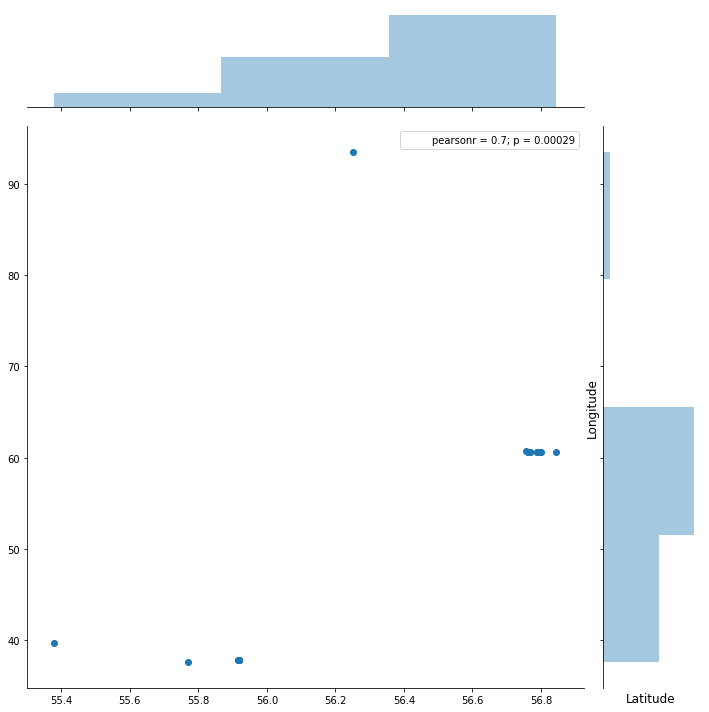

TypeError: 'module' object is not callable

In [180]:
plt.figure(figsize=(10,10))
sns.jointplot(x=pos['pos_address_lat'].values, y=pos['pos_address_lon'].values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
plt1 = plt()
sns.despine

In [133]:
pos.groupby(['pos_address_lat', 'pos_address_lon']).size().reset_index().rename(columns={0:'count'})

,pos_address_lat,pos_address_lon,count
0,55.378953,39.716725,1
1,55.770220,37.595111,1
2,55.915901,37.846252,2
3,55.918697,37.837501,4
4,56.250321,93.533796,1
5,56.756560,60.756839,1
6,56.762281,60.610211,3
7,56.768281,60.613289,1
8,56.769236,60.615424,1
9,56.787123,60.607165,2


In [143]:
train.groupby('customer_id')[['pos_address_lat', 'pos_address_lon']].max()

,pos_address_lat,pos_address_lon
customer_id,,
0,56.251347,43.446254
1,56.512737,86.172333
2,60.011047,38.189164
3,57.145240,131.108938
4,55.788354,136.648225
5,55.771642,45.216281
6,56.013577,37.637294
7,56.064305,92.907601
8,56.845195,93.533796


In [ ]:
freq = train.groupby('customer_id')

посчитаем частоты терминалов

In [146]:
atm = train[(train['atm_address'] !=0) | (train['atm_address_lat'] !=0)]

In [152]:
train.shape, atm.shape, pos.shape

((625504, 18), (108863, 18), (510128, 18))

In [151]:
pos = train[]

In [153]:
atm.shape[0] + pos.shape[0]

618991

In [158]:
atm_pos = train[(train['atm_address'] ==0) & (train['atm_address_lat'] ==0) & (train['pos_address'] ==0) & (train['pos_address_lat'] ==0)]

In [159]:
atm_pos.shape

(6513, 18)

In [160]:
atm_pos

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
302067,3.836768,0,0.0,0.0,"""Caf&#233","-bar Campus""",NaN,2575,55.901,37.401,7000,0,0.0,0.0,113422,NaN,55.533,37.618
942826,3.642087,0,0.0,0.0,MOSCOW,RU,643.0,2586,55.886,37.596,6011,0,0.0,0.0,242,2017-05-09,55.769,37.648
942990,3.609430,0,0.0,0.0,VYBORG G,RU,643.0,2807,60.010,30.294,6011,0,0.0,0.0,355,2017-07-01,59.829,30.078
943541,3.486681,0,0.0,0.0,Sankt-Peterbu,RU,643.0,2250,60.017,30.306,6011,0,0.0,0.0,614,2017-06-14,60.092,29.971
943593,4.538190,0,0.0,0.0,MOSKVA,RUS,978.0,4186,55.808,37.579,6011,0,0.0,0.0,636,2017-06-23,55.783,37.585
944470,3.168826,0,0.0,0.0,EKATERINBURG,RU,643.0,1046,56.771,60.595,6011,0,0.0,0.0,976,2017-08-06,56.777,60.606
944471,3.003194,0,0.0,0.0,EKATERINBURG,RU,643.0,1046,56.771,60.595,6011,0,0.0,0.0,976,2017-09-01,56.777,60.606
944472,3.602625,0,0.0,0.0,EKATERINBURG,RU,643.0,1046,56.771,60.595,6011,0,0.0,0.0,976,2017-09-22,56.777,60.606
944474,2.715058,0,0.0,0.0,EKATERINBURG,RU,643.0,1046,56.771,60.595,6011,0,0.0,0.0,976,2017-03-29,56.777,60.606
944485,3.481241,0,0.0,0.0,PERESVET,RU,643.0,251,56.371,38.595,6011,0,0.0,0.0,1038,2017-02-09,55.800,37.554


In [161]:
train[train['terminal_id'] == 113422]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
302067,3.836768,0,0.0,0.0,"""Caf&#233","-bar Campus""",NaN,2575,55.901,37.401,7000,0,0.0,0.0,113422,NaN,55.533,37.618


In [163]:
atm

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
942661,4.256019,"Москва, ул. Таганская, д. 17-23",55.741,37.665,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-06-27,55.741,37.664
942662,4.402484,"Москва, ул. Таганская, д. 17-23",55.741,37.667,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-11-02,55.741,37.664
942663,3.601407,"Москва, ул. Таганская, д. 17-23",55.743,37.662,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-02-10,55.741,37.664
942665,3.706789,"Москва, ул. Таганская, д. 17-23",55.737,37.667,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-07-03,55.741,37.664
942666,3.292168,"Москва, ул. Таганская, д. 17-23",55.744,37.666,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-06-29,55.741,37.664
942672,3.310562,"Москва, ул. Таганская, д. 17-23",55.738,37.667,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-03-31,55.741,37.664
942684,3.560758,"Москва, ул. Таганская, д. 17-23",55.738,37.661,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-11-17,55.741,37.664
942685,3.156450,"Москва, ул. Таганская, д. 17-23",55.738,37.665,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-09-14,55.741,37.664
942686,4.298580,"Москва, ул. Таганская, д. 17-23",55.738,37.664,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-09-07,55.741,37.664
942687,3.632761,"Москва, ул. Таганская, д. 17-23",55.739,37.662,MOSKVA,RUS,643.0,3371,55.824,37.804,6011,0,0.0,0.0,5,2017-05-26,55.741,37.664


In [170]:
train[train['atm_address'] == '0      BGRBGR']

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
1057682,3.692466,0 BGRBGR,0.0,0.0,SOFIA,BGR,975.0,1478,55.76,37.65,6011,0,0.0,0.0,114529,2017-06-05,56.043,92.903
1057683,4.001647,0 BGRBGR,0.0,0.0,SOFIA,BGR,975.0,1478,55.76,37.65,6011,0,0.0,0.0,114529,2017-06-07,56.043,92.903


In [172]:
train[train['customer_id'] == 1478]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
771070,2.352896,0,0.000,0.000,MOSCOW,RUS,643.0,1478,55.76,37.65,5411,39-6 DOLGORUKOVSKAYA STRMOSCOW127006 RUSRUS,55.778653,37.599963,102423,2017-09-28,56.043,92.903
771071,3.056547,0,0.000,0.000,MOSCOW,RUS,643.0,1478,55.76,37.65,5411,39-6 DOLGORUKOVSKAYA STRMOSCOW127006 RUSRUS,55.778653,37.599963,128614,2017-08-30,56.043,92.903
771072,2.165413,0,0.000,0.000,MOSKVA,RUS,643.0,1478,55.76,37.65,5812,"7,KOZHEVNICHESKAYAMOSKVA101000 RUSRUS",55.730623,37.645627,59724,2017-06-01,56.043,92.903
771073,2.132157,0,0.000,0.000,MOSKVA,RUS,643.0,1478,55.76,37.65,5814,"DOLGORUKOVSKAYA UL.,39/6MOSKVA 127006 ...",55.778653,37.599963,107577,2017-08-30,56.043,92.903
771074,2.475610,0,0.000,0.000,MOSKVA,RUS,643.0,1478,55.76,37.65,5814,"DOLGORUKOVSKAYA UL.,39/6MOSKVA 127006 ...",55.778653,37.599963,107577,2017-09-29,56.043,92.903
771075,2.582635,0,0.000,0.000,MOSKVA,RUS,643.0,1478,55.76,37.65,5814,"DOLGORUKOVSKAYA UL.,39/6MOSKVA 127006 ...",55.778653,37.599963,107577,2017-08-27,56.043,92.903
771076,2.340847,0,0.000,0.000,MOSKVA,RUS,643.0,1478,55.76,37.65,5814,"DOLGORUKOVSKAYA UL.,39/6MOSKVA 127006 ...",55.778653,37.599963,107577,2017-10-01,56.043,92.903
771077,2.690450,0,0.000,0.000,MOSCOW,RUS,643.0,1478,55.76,37.65,5411,39-6 DOLGORUKOVSKAYA STRMOSCOW127006 RUSRUS,55.778653,37.599963,128614,2017-09-29,56.043,92.903
771078,2.190131,0,0.000,0.000,MOSKVA,RUS,643.0,1478,55.76,37.65,5814,"DOLGORUKOVSKAYA UL.,39/6MOSKVA 127006 ...",55.778653,37.599963,107577,2017-08-30,56.043,92.903
771079,2.886107,0,0.000,0.000,MOSCOW,RUS,643.0,1478,55.76,37.65,5411,3 PODSOSENSKIY BYSTRMOSCOW105062 RUSRUS,55.759094,37.650442,77447,2017-09-28,56.043,92.903


In [184]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625504 entries, 0 to 1224733
Data columns (total 18 columns):
amount              625504 non-null float64
atm_address         625504 non-null object
atm_address_lat     625504 non-null float64
atm_address_lon     625504 non-null float64
city                625501 non-null object
country             625504 non-null object
currency            625503 non-null float64
customer_id         625504 non-null int64
home_add_lat        625504 non-null float64
home_add_lon        625504 non-null float64
mcc                 625504 non-null int64
pos_address         625504 non-null object
pos_address_lat     625504 non-null float64
pos_address_lon     625504 non-null float64
terminal_id         625504 non-null int64
transaction_date    625503 non-null object
work_add_lat        625504 non-null float64
work_add_lon        625504 non-null float64
dtypes: float64(10), int64(3), object(5)
memory usage: 90.7+ MB


In [185]:
atm_train = train[train['atm_address']!=0]

In [186]:
len(atm_train['atm_address'].unique())

1559

In [ ]:
wrong_pos_address = []
with open('pos_address.txt', 'r') as file:
    for line in file:
        wrong_pos_address.append(line.strip())

In [193]:
atm_train[atm_train['atm_address'] == wrong_address]

ValueError: Arrays were different lengths: 107357 vs 52

In [ ]:
atm_train.drop(,inplace=True)

In [ ]:
atm_lat = []
atm_lon = []
wrong_address = []
for address in tqdm(atm_train['atm_address'].unique()[170:]):
    try:
        location = geolocator.geocode(address)
    except:
        print(address)
        time.sleep(0.5)
        location = geolocator.geocode(address)
    try:
        atm_lat.append(location.latitude)
    except:
        wrong_address.append(address)
        with open('atm_address.txt', 'w') as file:
            for item in wrong_address:
                file.write("%s\n" % item)
    time.sleep(0.1)
        

In [ ]:
location = geolocator.geocode("MOSCOW")

m = folium.Map(location=[location.latitude, location.longitude], zoom_start=3)
#folium.Marker([location.latitude, location.longitude], popup='<i>True</i>', icon=folium.Icon(color='red', icon='font')).add_to(m)
pos = train[train['customer_id'] == 8]
for i in range(pos.shape[0]):
    pos_lat = pos['pos_address_lat'].values[i]
    pos_lon = pos['pos_address_lon'].values[i]

    folium.Marker([pos_lat, pos_lon], popup='pos' + str(i), icon=folium.Icon(color='blue', icon='usd')).add_to(m)
    
h_lat = pos['home_add_lat'].values[0]
h_lon = pos['home_add_lon'].values[0]
w_lat = pos['work_add_lat'].values[0]
w_lon = pos['work_add_lon'].values[0]
folium.Marker([h_lat, h_lon], popup='<i>Home</i>', icon=folium.Icon(color='green', icon='home')).add_to(m)
folium.Marker([h_lon, h_lat], popup='<i>Home</i>', icon=folium.Icon(color='red', icon='home')).add_to(m)
folium.Marker([w_lat, w_lon], popup='<i>Work</i>', icon=folium.Icon(color='red', icon='briefcase')).add_to(m)
m